In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.utils import plot_model
import numpy as np
import random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [2]:
# Load the dataset
file_path = r"D:\7th Semester\AI\Tamil-SpellGrammar-Checker\data\grammar_checker_dataset\final_dataset.csv"
file_path2 = r"D:\7th Semester\AI\Tamil-SpellGrammar-Checker\data\grammar_checker_dataset\tamildataset.xlsx"
df = pd.read_csv(file_path)
df2 = pd.read_excel(file_path2)
# Display the first few rows of the dataset to understand its structure
df.head()

,Error Sentence,Error Type,Corrected Sentence
0,அவள் பாடல்கள் பாடுகிறான்.,Subject-Verb Agreement,அவள் பாடல்கள் பாடுகிறாள்.
1,நாங்கள் நேரம் பழகுகிறேன்.,Subject-Verb Agreement,நாங்கள் நேரம் பழகுகிறோம்.
2,அவன் புத்தகத்தை படிக்கிறார்கள்.,Subject-Verb Agreement,அவன் புத்தகத்தை படிக்கிறான்.
3,அவர்கள் விளையாட்டு விளையாடுகிறேன்.,Subject-Verb Agreement,அவர்கள் விளையாட்டு விளையாடுகிறார்கள்.
4,நான் வீட்டில் வேலை செய்கிறார்கள்.,Subject-Verb Agreement,நான் வீட்டில் வேலை செய்கிறேன்.


### Data Preprocessing

In [3]:
df = df.dropna(subset=['Error Sentence', 'Corrected Sentence'])

df['Error Sentence'] = df['Error Sentence'].astype(str)
df['Corrected Sentence'] = df['Corrected Sentence'].astype(str)

# Separate the ungrammatical sentences (input) and corrected Sentence sentences (target)
input_sentences = df['Error Sentence'].values
target_sentences = ['<start> ' + sentence + ' <end>' for sentence in df['Corrected Sentence'].values]

In [4]:
input_sentences[0:2]

array(['அவள் பாடல்கள் பாடுகிறான்.', 'நாங்கள் நேரம் பழகுகிறேன்.'],
      dtype=object)

In [5]:
target_sentences[0:2]

['<start> அவள் பாடல்கள் பாடுகிறாள். <end>',
 '<start> நாங்கள் நேரம் பழகுகிறோம். <end>']

### Tokenization

In [6]:
# Tokenize the input sentences 
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_sentences)
input_sequences = input_tokenizer.texts_to_sequences(input_sentences)

# Tokenize the target sentences
output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_sentences)
target_sequences = output_tokenizer.texts_to_sequences(target_sentences)

In [7]:
input_sequences[0:2]

[[5, 21, 13], [4, 19, 22]]

In [8]:
target_sequences[0:2]

[[1, 7, 26, 20, 2], [1, 6, 21, 24, 2]]

In [9]:
# Save input tokenizer
with open('input_tokenizer.pkl', 'wb') as f:
    pickle.dump(input_tokenizer, f)

# Save output tokenizer
with open('output_tokenizer.pkl', 'wb') as f:
    pickle.dump(output_tokenizer, f)

In [10]:
len(input_tokenizer.word_index), len(output_tokenizer.word_index)

(660, 664)

In [11]:
print({index: input_tokenizer.index_word[index] for index in range(1, 11)})
print({index: output_tokenizer.index_word[index] for index in range(1, 11)})

{1: 'நான்', 2: 'அவர்கள்', 3: 'அவன்', 4: 'நாங்கள்', 5: 'அவள்', 6: 'படிக்கிறார்கள்', 7: 'வீட்டில்', 8: 'தினமும்', 9: 'நீங்கள்', 10: 'வேலை'}
{1: 'start', 2: 'end', 3: 'நான்', 4: 'அவர்கள்', 5: 'அவன்', 6: 'நாங்கள்', 7: 'அவள்', 8: 'வீட்டில்', 9: 'தினமும்', 10: 'நீங்கள்'}


In [12]:
len(input_tokenizer.word_index)+1

661

### Find Maximum Sequence Lengths and Padding

In [13]:
# Find the maximum sequence lengths
max_input_length = max(len(seq) for seq in input_sequences)
max_target_length = max(len(seq) for seq in target_sequences)

# Pad sequences to ensure equal length
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_length, padding='post')

In [14]:
print(f"max_input_length: {max_input_length}")
print(f"max_target_length: {max_target_length}")
print(f"encoder_input_data.shape: {encoder_input_data.shape}")
print(f"decoder_input_data.shape: {decoder_input_data.shape}")

max_input_length: 8
max_target_length: 10
encoder_input_data.shape: (999, 8)
decoder_input_data.shape: (999, 10)


In [15]:
decoder_input_data

array([[ 1,  7, 26, ...,  0,  0,  0],
       [ 1,  6, 21, ...,  0,  0,  0],
       [ 1,  5, 15, ...,  0,  0,  0],
       ...,
       [ 1,  4, 80, ...,  0,  0,  0],
       [ 1,  5, 56, ...,  0,  0,  0],
       [ 1,  3, 19, ...,  0,  0,  0]])

### Prepare Decoder Output Data (One-hot Encoding)

In [16]:
# Prepare decoder output data (shifted by 1 position for teacher forcing)
decoder_output_data = np.zeros((len(target_sequences), max_target_length, len(output_tokenizer.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, word_id in enumerate(seq):
        if t > 0:  # Skip the first token (start token)
            decoder_output_data[i, t - 1, word_id] = 1.0

In [17]:
decoder_output_data.shape

(999, 10, 665)

In [18]:
decoder_output_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Train-Test Split

In [19]:
# Train-Test Split
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_output_train, decoder_output_val = train_test_split(
                                                                                                                                        encoder_input_data, decoder_input_data, decoder_output_data, 
                                                                                                                                        test_size=0.2, random_state=42)


In [20]:
print(f"encoder_input_train.shape: {encoder_input_train.shape}")
print(f"encoder_input_val.shape: {encoder_input_val.shape}")
print(f"decoder_input_train.shape: {decoder_input_train.shape}")
print(f"decoder_input_val.shape: {decoder_input_val.shape}")
print(f"decoder_output_train.shape: {decoder_output_train.shape}")
print(f"decoder_output_val.shape: {decoder_output_val.shape}")

encoder_input_train.shape: (799, 8)
encoder_input_val.shape: (200, 8)
decoder_input_train.shape: (799, 10)
decoder_input_val.shape: (200, 10)
decoder_output_train.shape: (799, 10, 665)
decoder_output_val.shape: (200, 10, 665)


### Build the Seq2Seq Model

In [21]:
# Set model parameters (modified)
embedding_dim = 256 
hidden_units = 1024 
dropout_rate = 0.5  
batch_size = 32  
learning_rate = 0.0005

# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_dim=len(input_tokenizer.word_index) + 1, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(hidden_units, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
_, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_target_length,))
decoder_embedding = Embedding(input_dim=len(output_tokenizer.word_index) + 1, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(output_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model with the modified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to confirm the architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 8, 256)    │    169,216 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 256)   │    170,240 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 1024),    │  5,246,976 │ embedding[0][0]   │
│                     │ (None, 1024),     │            │                   │
│                     │ (None, 1024)]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 10,       │  5,246,976 │ embedding_1[0][0… │
│                     │ 1024), (None,     │            │ lstm[0][1],       │
│                     │ 1024), (None,     │            │ lstm[0][2]        │
│                     │ 1024)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 665)   │    681,625 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,515,033 (43.93 MB)

 Trainable params: 11,515,033 (43.93 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [22]:
epochs = 25
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_output_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([encoder_input_val, decoder_input_val], decoder_output_val)
)


Epoch 1/25


c:\Users\Hp\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_5']. Received: the structure of inputs=('*', '*')
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 671ms/step - accuracy: 0.0859 - loss: 2.6473 - val_accuracy: 0.1170 - val_loss: 1.9140
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 619ms/step - accuracy: 0.1200 - loss: 1.7640 - val_accuracy: 0.1285 - val_loss: 1.8141
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 610ms/step - accuracy: 0.1328 - loss: 1.6102 - val_accuracy: 0.1405 - val_loss: 1.7410
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 625ms/step - accuracy: 0.1432 - loss: 1.5170 - val_accuracy: 0.1435 - val_loss: 1.6787
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 621ms/step - accuracy: 0.1465 - loss: 1.4017 - val_accuracy: 0.1585 - val_loss: 1.6128
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 623ms/step - accuracy: 0.1639 - loss: 1.3912 - val_accuracy: 0.1745 - val_loss: 1.5411
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 732ms/step - accuracy: 0.1861 - loss: 1.3266 - val_accuracy: 0.2320 - val_loss: 1.4508
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 749ms/step - accuracy: 0.2283 - loss: 1.2088 - val_accuracy: 0.235

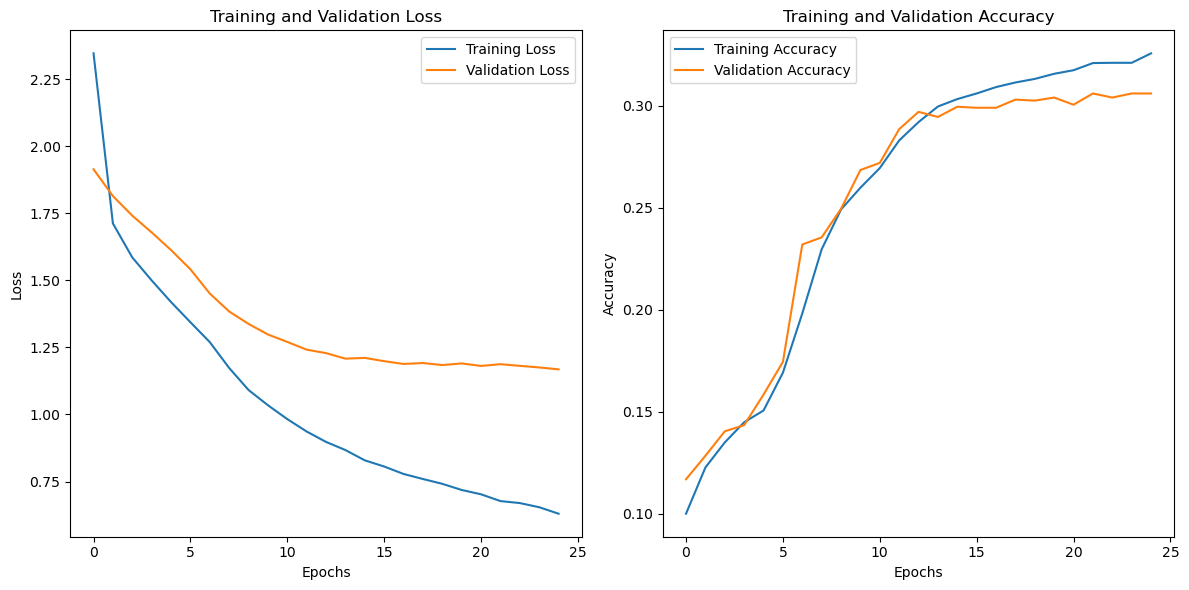

In [23]:
# Extracting the history data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the loss curves
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [24]:
# Save the model
model.save('./Models/grammar_checker_model.h5')

### Evaluate the Model

In [41]:
# Evaluate the model on the validation data
validation_loss, validation_accuracy = model.evaluate([encoder_input_val, decoder_input_val], decoder_output_val)
train_loss, train_accuracy = model.evaluate([encoder_input_train, decoder_input_train], decoder_output_train)

# print(f"Training Loss: {train_loss * 100:.2f}%")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
# print(f"Validation Loss: {validation_loss * 100:.2f}%")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.2993 - loss: 1.2174
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.3387 - loss: 0.5766
Training Accuracy: 33.34%
Validation Accuracy: 30.60%


### Create Inference Models (for Prediction)

In [26]:
# Inference
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_embedding_inf = Embedding(input_dim=len(output_tokenizer.word_index) + 1, output_dim=embedding_dim)(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

### Test the Model with Grammatical Error Sentences

In [27]:
error_sentences = [
    "நான் நேற்று பாடம் படிக்கிறேன்.",
    "அவள் பாடம் படித்தான்."
]

correct_sentences = [
    "நான் நேற்று பாடம் படித்தேன்.",
    "அவள் பாடம் படித்தாள்."
]


In [28]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = output_tokenizer.word_index['start']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = None
        for word, index in output_tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break
        if sampled_word == 'end' or len(decoded_sentence.split()) > max_target_length:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence.strip()

In [29]:
# Test the model with random sentences
random_indices = random.sample(range(len(input_sentences)), 5)
selected_test_inputs = [input_sentences[i] for i in random_indices]
selected_test_targets = [target_sentences[i] for i in random_indices]
predictions = []
references = []
for input_sentence, target_sentence in zip(selected_test_inputs, selected_test_targets):
    input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=8, padding='post')
    predicted_sentence = decode_sequence(input_seq)
    predictions.append(predicted_sentence.split())
    references.append([target_sentence.split()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


c:\Users\Hp\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_5', 'keras_tensor_11', 'keras_tensor_12']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [30]:
# Define the ungrammatical input sentence
input_sentence = "நான் நேற்று பாடம் படிக்கிறேன்."  # Example ungrammatical sentence

# Preprocess the input sentence
input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=max_input_length, padding='post')

# Get the predicted sentence using the model
predicted_sentence = decode_sequence(input_seq)

# Output the result
print("Input Sentence (Ungrammatical):", input_sentence)
print("Predicted Sentence (Grammatical):", predicted_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Input Sentence (Ungrammatical): நான் நேற்று பாடம் படிக்கிறேன்.
Predicted Sentence (Grammatical): நான் நகரத்தில் படிக்கிறேன்


In [31]:
# Define the ungrammatical input sentence
input_sentence = "அவள் பாடம் படித்தான்."  # Example ungrammatical sentence

# Preprocess the input sentence
input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=max_input_length, padding='post')

# Get the predicted sentence using the model
predicted_sentence = decode_sequence(input_seq)

# Output the result
print("Input Sentence (Ungrammatical):", input_sentence)
print("Predicted Sentence (Grammatical):", predicted_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Input Sentence (Ungrammatical): அவள் பாடம் படித்தான்.
Predicted Sentence (Grammatical): அவள் நகரத்தில் கடந்து


In [32]:
# Test model on both error and correct sentences
predictions_error = []
predictions_correct = []

# Preprocess and get predictions for error sentences
for input_sentence in error_sentences:
    # Apply padding and truncation based on the expected input length of the model
    input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=5, padding='post', truncating='post')
    predicted_sentence = decode_sequence(input_seq)
    predictions_error.append(predicted_sentence)

# Preprocess and get predictions for correct sentences
for input_sentence in correct_sentences:
    input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=5, padding='post', truncating='post')
    predicted_sentence = decode_sequence(input_seq)
    predictions_correct.append(predicted_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [33]:
predictions_correct

['தினமும் தினமும் புதிய', 'நீங்கள் தினமும் புதிய']

### Evaluating BLEU Scores

In [34]:
from nltk.translate.bleu_score import sentence_bleu

# Reference sentences for error sentences
references_error = [
    ["நான் நேற்று பாடம் படித்தேன்."],  # Expected grammatical sentences
    ["அவள் பாடம் படித்தாள்."]
]

# Reference sentences for correct sentences

references_correct = [
    ["நான் நேற்று பாடம் படித்தேன்."],
    ["அவள் பாடம் படித்தாள்."]
]

# Calculate BLEU scores for the error sentences
bleu_scores_error = [sentence_bleu(ref, pred, weights=(0.5, 0.5)) for pred, ref in zip(predictions_error, references_error)]

# Calculate BLEU scores for the correct sentences
bleu_scores_correct = [sentence_bleu(ref, pred, weights=(0.5, 0.5)) for pred, ref in zip(predictions_correct, references_correct)]

# Compute average BLEU score for both sets
avg_bleu_score_error = sum(bleu_scores_error) / len(bleu_scores_error)
avg_bleu_score_correct = sum(bleu_scores_correct) / len(bleu_scores_correct)

# Display BLEU scores
print("BLEU Scores for Error Sentences:")
for i, score in enumerate(bleu_scores_error):
    print(f"Sentence {i+1} BLEU Score: {score:.4f}")
print(f"Average BLEU Score for Error Sentences: {avg_bleu_score_error:.4f}")

print("\nBLEU Scores for Correct Sentences:")
for i, score in enumerate(bleu_scores_correct):
    print(f"Sentence {i+1} BLEU Score: {score:.4f}")
print(f"Average BLEU Score for Correct Sentences: {avg_bleu_score_correct:.4f}")

BLEU Scores for Error Sentences:
Sentence 1 BLEU Score: 0.2521
Sentence 2 BLEU Score: 0.3619
Average BLEU Score for Error Sentences: 0.3070

BLEU Scores for Correct Sentences:
Sentence 1 BLEU Score: 0.2422
Sentence 2 BLEU Score: 0.3619
Average BLEU Score for Correct Sentences: 0.3021


In [35]:
input_sentence = "அவர்கள் விளையாட்டு விளையாடுகிறேன்"
input_sequence = input_tokenizer.texts_to_sequences([input_sentence])
input_sequence

[[2, 11, 12]]

In [36]:
# Tokenizing the input paragraph
input_seq = pad_sequences(input_sequence, maxlen=max_input_length, padding='post')
input_seq

array([[ 2, 11, 12,  0,  0,  0,  0,  0]])

In [37]:
# Get the prediction
corrected_paragraph = decode_sequence(input_seq)

# Step 5: Display the results
print("Input Paragraph (with errors):")
print(input_sentence)

print("\nCorrected Paragraph (Predicted by the model):")
print(corrected_paragraph)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input Paragraph (with errors):
அவர்கள் விளையாட்டு விளையாடுகிறேன்

Corrected Paragraph (Predicted by the model):
அவர்கள் விளையாட்டு விளையாடுகிறார்கள்


In [40]:
# Define the ungrammatical input paragraph
input_paragraph = """
அவர்கள் விளையாட்டு விளையாடுகிறேன் 
நான் பாடல்களை படிக்கிறார்கள்.
நாங்கள் உணவு சாப்பிடுகிறான்.
"""

input_sentences = input_paragraph.strip().split("\n")

corrected_sentences = []

# Process each sentence in the paragraph
for input_sentence in input_sentences:
    input_seq = pad_sequences(
        input_tokenizer.texts_to_sequences([input_sentence]), 
        maxlen=max_input_length, 
        padding='post'
    )

    predicted_sentence = decode_sequence(input_seq)
    corrected_sentences.append(predicted_sentence)

corrected_paragraph = ". ".join(corrected_sentences)

# Output the results
print("Input Paragraph (Ungrammatical):")
print(input_paragraph)
print("\nCorrected Paragraph (Grammatical):")
print(corrected_paragraph)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input Paragraph (Ungrammatical):

அவர்கள் விளையாட்டு விளையாடுகிறேன் 
நான் பாடல்களை படிக்கிறார்கள்.
நாங்கள் உணவு சாப்பிடுகிறான்.


Corrected Paragraph (Grammatical):
அவர்கள் விளையாட்டு விளையாடுகிறார்கள். நான் பாடல்களை படிக்கிறேன். நாங்கள் உணவு சாப்பிடுகிறோம்
